In [33]:
import pandas as pd
import numpy as np


from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support


from sklearn.model_selection import GridSearchCV

import optuna
from optuna.integration import OptunaSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

import seaborn as sns
import itertools



In [70]:
df = pd.read_parquet("df_preprocessed_windows.parquet")

#split:
train_cycles = ["A1", "A2"]
val_cycles   = ["B1"]
test_cycles  = ["B2"]

df_train = df[df["cycle_id"].isin(train_cycles)].copy()
df_val   = df[df["cycle_id"].isin(val_cycles)].copy()
df_test  = df[df["cycle_id"].isin(test_cycles)].copy()

print("Train size:", df_train.shape)
print("Val size:", df_val.shape)
print("Test size:", df_test.shape)
print("Positive rates:",
      df_train["label"].mean(),
      df_val["label"].mean(),
      df_test["label"].mean())


Train size: (8601, 28)
Val size: (1896, 28)
Test size: (3552, 28)
Positive rates: 0.039065224973840254 0.08860759493670886 0.0472972972972973


In [66]:
# features

feature_cols_full = [
    c for c in df.columns
    if c not in ["pump_id", "cycle_id", "end_time", "label"]
]

feature_cols_reduced = [
    "delta_p_mean",
    "delta_p_std",
    "delta_p_trend",
    "output_mean",
    "output_std",
    "output_trend",
    "active_pressure_fraction",
]

FEATURE_SET = "reduced"      #  "full or "reduced"----=

if FEATURE_SET == "full":
    feature_cols = feature_cols_full
elif FEATURE_SET == "reduced":
    feature_cols = feature_cols_reduced

    

X_train = df_train[feature_cols]
y_train = df_train["label"]

X_val = df_val[feature_cols]
y_val = df_val["label"]

X_test = df_test[feature_cols]
y_test = df_test["label"]

#==========================use for all models!




In [67]:
lr_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10, 100]
}


In [68]:
grid = GridSearchCV(
    estimator=lr_pipe,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC (primary metric)
    cv=[(np.arange(len(X_train)), np.arange(len(X_val)))],
    refit=True
)

# Fit: training data only
grid.fit(
    pd.concat([X_train, X_val]),
    pd.concat([y_train, y_val])
)

print("\nBest Logistic Regression parameters:")
print(grid.best_params_)

best_model = grid.best_estimator_
best_C = best_model.named_steps["clf"].C
print("Best C used:", best_C)




Best Logistic Regression parameters:
{'clf__C': 100}
Best C used: 100


In [55]:
y_val_pred  = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

print("\n=== VALIDATION RESULTS ===")
print(classification_report(y_val, y_val_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("PR-AUC :", average_precision_score(y_val, y_val_proba))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))



=== VALIDATION RESULTS ===
              precision    recall  f1-score   support

           0      1.000     0.884     0.938      1728
           1      0.455     1.000     0.626       168

    accuracy                          0.894      1896
   macro avg      0.728     0.942     0.782      1896
weighted avg      0.952     0.894     0.911      1896

ROC-AUC: 0.999975887345679
PR-AUC : 0.9997506703916155
Confusion matrix:
 [[1527  201]
 [   0  168]]


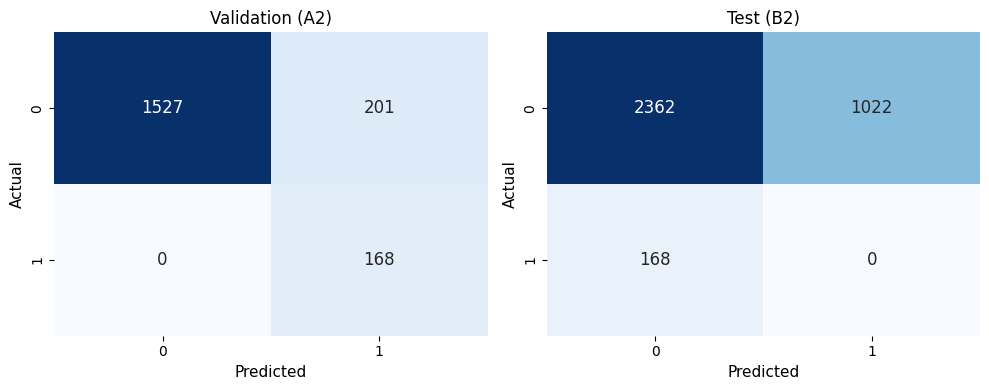

Validation confusion matrix:
 [[1527  201]
 [   0  168]]
Test confusion matrix:
 [[2362 1022]
 [ 168    0]]


In [56]:

y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

cm_val = confusion_matrix(y_val, y_val_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(
    cm_val, annot=True, fmt="d", cmap="Blues",
    cbar=False, ax=axes[0], annot_kws={"size": 12}
)
axes[0].set_title("Validation (A2)", fontsize=12)
axes[0].set_xlabel("Predicted", fontsize=11)
axes[0].set_ylabel("Actual", fontsize=11)

sns.heatmap(
    cm_test, annot=True, fmt="d", cmap="Blues",
    cbar=False, ax=axes[1], annot_kws={"size": 12}
)
axes[1].set_title("Test (B2)", fontsize=12)
axes[1].set_xlabel("Predicted", fontsize=11)
axes[1].set_ylabel("Actual", fontsize=11)

plt.tight_layout()
plt.show()

print("Validation confusion matrix:\n", cm_val)
print("Test confusion matrix:\n", cm_test)


                    feature  importance_mean  importance_std
4                output_std         0.328629        0.016157
0              delta_p_mean         0.230627        0.011639
1               delta_p_std         0.221600        0.010478
3               output_mean         0.175588        0.011172
5              output_trend         0.113539        0.005540
6  active_pressure_fraction         0.104099        0.005549
2             delta_p_trend         0.100913        0.009548


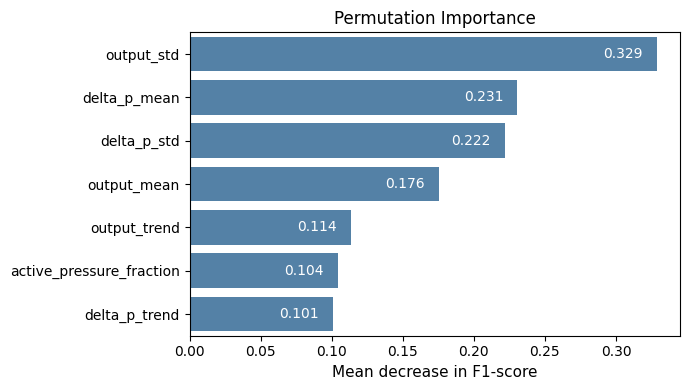

In [69]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    best_model,
    X_val,
    y_val,
    scoring="f1",
    n_repeats=30,
    random_state=42
)

perm_df = (
    pd.DataFrame({
        "feature": feature_cols,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

print(perm_df)

plt.figure(figsize=(7, 4))
ax = sns.barplot(
    data=perm_df,
    x="importance_mean",
    y="feature",
    color="steelblue"
)

ax.set_xlabel("Mean decrease in F1-score", fontsize=11)
ax.set_ylabel("")
ax.set_title("Permutation Importance", fontsize=12)

# ---- ADD VALUES INSIDE THE BARS ----
for i, row in perm_df.iterrows():
    value = row["importance_mean"]
    ax.text(
        value - 0.01 if value > 0 else value + 0.01,  # place inside bar
        perm_df.index.get_loc(i),
        f"{value:.3f}",
        va="center",
        ha="right" if value > 0 else "left",
        color="white",
        fontsize=10
    )

plt.tight_layout()
plt.show()


In [59]:
from sklearn.metrics import f1_score, roc_auc_score

def cross_line_eval(train_line, test_line):
    df_tr = df[df["pump_id"] == train_line]
    df_te = df[df["pump_id"] == test_line]

    X_tr = df_tr[feature_cols]
    y_tr = df_tr["label"]
    X_te = df_te[feature_cols]
    y_te = df_te["label"]

    model = Pipeline([
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(
            C=best_C,
            max_iter=1000,
            class_weight="balanced",
            random_state=42
        ))
    ])

    model.fit(X_tr, y_tr)

    y_score = model.predict_proba(X_te)[:, 1]
    y_pred = model.predict(X_te)

    return {
        "F1": f1_score(y_te, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y_te, y_score),
        "CM": confusion_matrix(y_te, y_pred),
        "PR_AUC": average_precision_score (y_te, y_pred)
    }

res_A_B = cross_line_eval("A", "B")
res_B_A = cross_line_eval("B", "A")

print("A → B:", res_A_B)
print("B → A:", res_B_A)


A → B: {'F1': 0.22764227642276422, 'ROC_AUC': np.float64(0.7278891835156336), 'CM': array([[7648,  972],
       [ 168,  168]]), 'PR_AUC': np.float64(0.09244258480054535)}
B → A: {'F1': 0.20947630922693267, 'ROC_AUC': np.float64(0.8792171798296784), 'CM': array([[5913, 2536],
       [   0,  336]]), 'PR_AUC': np.float64(0.116991643454039)}


In [19]:
print([c for c in df.columns if "dm" in c.lower()])


['dm1_mean', 'dm1_std', 'dm2_mean', 'dm2_std', 'dm3_mean', 'dm3_std']


In [63]:
df_b2 = df_test.copy()
dm_threshold = df_b2["dm1_mean"].mean()

low_dm = df_b2[df_b2["dm1_mean"] <= dm_threshold]
high_dm = df_b2[df_b2["dm1_mean"] > dm_threshold]

def eval_subset(df_subset):
    X = df_subset[feature_cols]
    y = df_subset["label"]
    y_score = best_model.predict_proba(X)[:, 1]
    y_pred = best_model.predict(X)

    if y.sum() == 0:
        return {"F1": 0.0, "ROC_AUC": None, "CM": confusion_matrix(y, y_pred) ,
        "PR_AUC": average_precision_score (y, y_pred)}

    return {
        "F1": f1_score(y, y_pred, zero_division=0),
        "ROC_AUC": roc_auc_score(y, y_score),
        "CM": confusion_matrix(y, y_pred),
        "PR_AUC": average_precision_score (y, y_pred)
    }

low_res = eval_subset(low_dm)
high_res = eval_subset(high_dm)

print("Low dry matter:", low_res)
print("High dry matter:", high_res)


Low dry matter: {'F1': 0.0, 'ROC_AUC': None, 'CM': array([[967, 925],
       [  0,   0]]), 'PR_AUC': 0.0}
High dry matter: {'F1': 0.0, 'ROC_AUC': np.float64(0.10387144133792926), 'CM': array([[1395,   97],
       [ 168,    0]]), 'PR_AUC': np.float64(0.10120481927710843)}


/Users/teunlangenhuijsen/thesis_env/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
